<a href="https://colab.research.google.com/github/Shipraparida/Handwritten-Digit-Recognizer/blob/main/Handwritten_Digit_Recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab  import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# LOAD THE DATA
import pandas as pd

train =pd.read_csv("/content/drive/MyDrive/datasets/train.csv")
test =pd.read_csv("/content/drive/MyDrive/datasets/test.csv")

In [ ]:
# PREPARE DATA FOR NEURAL NETWORK
from tensorflow.keras.utils import to_categorical

Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1)
X_train = X_train / 255.0
X_test = test / 255.0
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)
Y_train = to_categorical(Y_train, num_classes = 10)

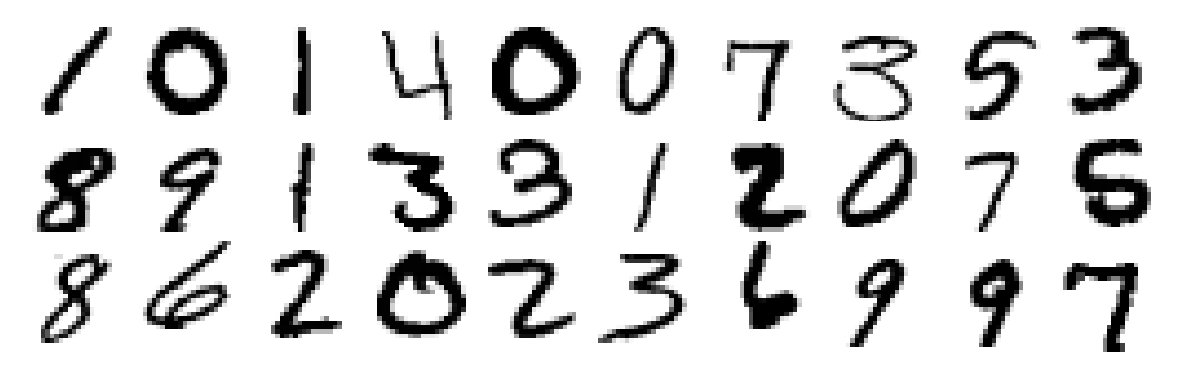

In [ ]:
import matplotlib.pyplot as plt
# PREVIEW IMAGES
plt.figure(figsize=(15,4.5))
for i in range(30):
    plt.subplot(3, 10, i+1)
    plt.imshow(X_train[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

In [ ]:
# CREATE MORE IMAGES VIA DATA AUGMENTATION
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range = 0.10,
        width_shift_range=0.1,
        height_shift_range=0.1)

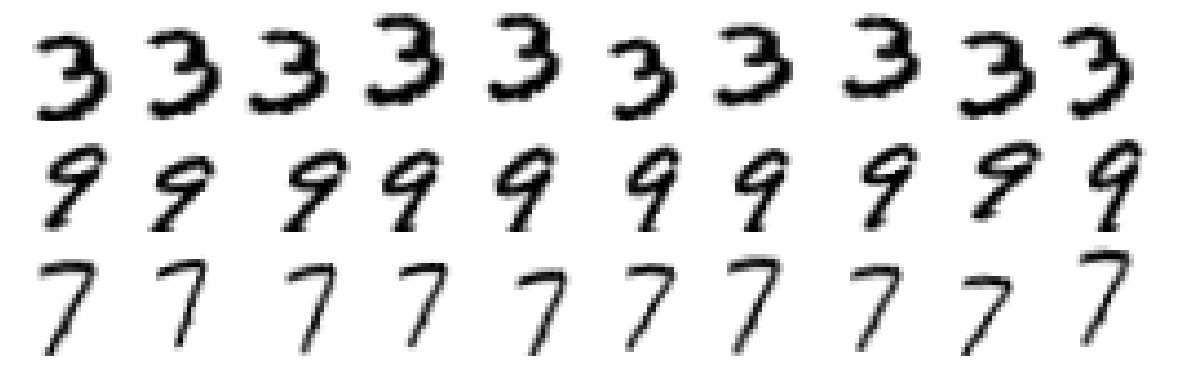

In [ ]:
# PREVIEW AUGMENTED IMAGES
X_train3 = X_train[9,].reshape((1,28,28,1))
Y_train3 = Y_train[9,].reshape((1,10))

plt.figure(figsize=(15,4.5))
for i in range(30):
    plt.subplot(3, 10, i+1)

    # Use next() instead of .next()
    X_train2, Y_train2 = next(datagen.flow(X_train3, Y_train3))

    plt.imshow(X_train2[0].reshape((28,28)), cmap=plt.cm.binary)
    plt.axis('off')

    # Switch to different samples at i=9 and i=19
    if i == 9:
        X_train3 = X_train[11,].reshape((1,28,28,1))
        Y_train3 = Y_train[11,].reshape((1,10))
    if i == 19:
        X_train3 = X_train[18,].reshape((1,28,28,1))
        Y_train3 = Y_train[18,].reshape((1,10))

plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Flatten, Dense

# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 15
model = [0] * nets

for j in range(nets):
    model[j] = Sequential()

    model[j].add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size=3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size=5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(64, kernel_size=3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size=3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size=5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(128, kernel_size=4, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Flatten())
    model[j].add(Dropout(0.4))
    model[j].add(Dense(10, activation='softmax'))

    # COMPILE WITH ADAM OPTIMIZER AND CROSS ENTROPY COST
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import LearningRateScheduler

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# TRAIN NETWORKS
history = [0] * nets
epochs = 45

for j in range(nets):
    # Split training into train/validation
    X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size=0.1)

    # Train model with generator
    history[j] = model[j].fit(
        datagen.flow(X_train2, Y_train2, batch_size=64),
        epochs=epochs,
        steps_per_epoch=X_train2.shape[0] // 64,
        validation_data=(X_val2, Y_val2),
        callbacks=[annealer],
        verbose=0
    )

    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        j+1,
        epochs,
        max(history[j].history['accuracy']),
        max(history[j].history['val_accuracy'])
    ))


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


CNN 1: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99810
CNN 2: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99595
CNN 3: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99548
CNN 4: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99714
CNN 5: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99667
CNN 6: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99619
CNN 7: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99500
CNN 8: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99548
CNN 9: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99405
CNN 10: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99500
CNN 11: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99548
CNN 12: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99690
CNN 13: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99524
CNN 14: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99429
CNN 15: Epochs=

In [ ]:
# ENSEMBLE PREDICTIONS AND SUBMIT
import numpy as np
results = np.zeros( (X_test.shape[0],10) )
for j in range(nets):
    results = results + model[j].predict(X_test)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("MNIST-CNN-ENSEMBLE.csv",index=False)

875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


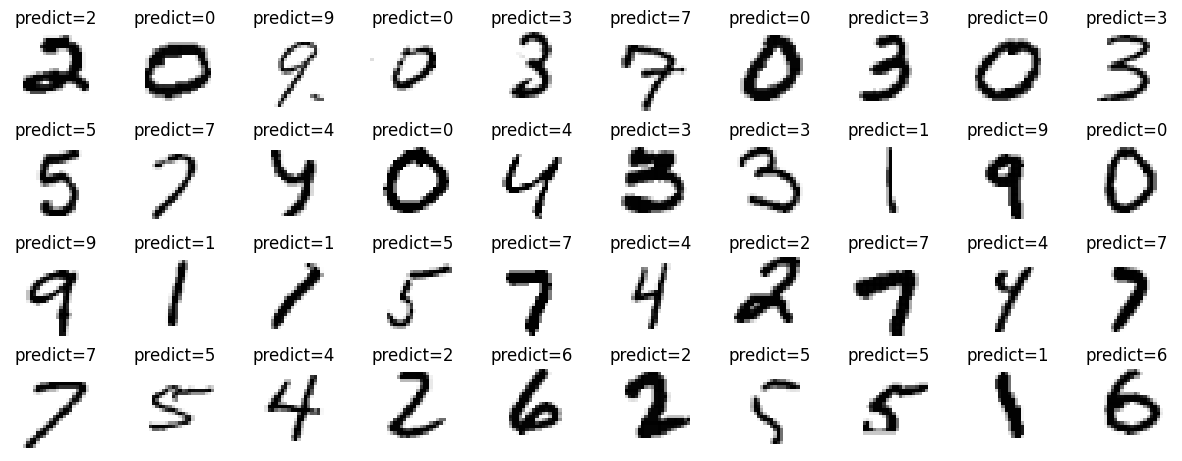

In [ ]:
# PREVIEW PREDICTIONS
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))
for i in range(40):
    plt.subplot(4, 10, i+1)
    plt.imshow(X_test[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.title("predict=%d" % results[i],y=0.9)
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()